# Introduction
We will predict library visitors in Australian cities using AutoGluon. We will set up the environment, explore the data, build models, add covariates, and interpret feature importance.

In the end, we'll see how these techniques help us make accurate and explainable forecasts.

# Setup: Libraries and Data

We mount Google Drive, change the directory to the project folder, install the AutoGluon library, import the required libraries, and load the dataset that shows library visitors in Australian cities.


In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Change directory to the project folder
%cd /content/drive/MyDrive/Python - Time Series Forecasting/Advanced Content for Time Series /Amazon AutoGluon

/content/drive/MyDrive/Python - Time Series Forecasting/Advanced Content for Time Series /Amazon AutoGluon


In [3]:
# Install the autogluon library
!pip install -q autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.2/266.2 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.1/64.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.0/430.0 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.2/352.2 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.timeseries.splitter import ExpandingWindowSplitter

In [5]:
# Load the data
# This dataset shows the number of library visitors across various Australian cities
df = pd.read_csv("australia_library_data.csv")
df.head()

,datetime,location_name,no_of_people,day_of_week,temperature,rainfall,event_day
0,2024-06-01 00:00:00,Sydney,3,5,14.811082,0,1
1,2024-06-01 01:00:00,Sydney,3,5,15.545415,0,1
2,2024-06-01 02:00:00,Sydney,3,5,15.585101,0,1
3,2024-06-01 03:00:00,Sydney,3,5,14.263018,1,1
4,2024-06-01 04:00:00,Sydney,4,5,15.611136,1,1


We have our environment set up and our dataset loaded. Now we can proceed with data processing.

# Data Processing and Visualization

We rename the target column, preview the data, plot the target, and assess its basic structure.

In [6]:
# Rename the target variable for easier referencing in our modeling steps
df.rename(columns={'no_of_people': 'y'}, inplace = True)
df.head()

,datetime,location_name,y,day_of_week,temperature,rainfall,event_day
0,2024-06-01 00:00:00,Sydney,3,5,14.811082,0,1
1,2024-06-01 01:00:00,Sydney,3,5,15.545415,0,1
2,2024-06-01 02:00:00,Sydney,3,5,15.585101,0,1
3,2024-06-01 03:00:00,Sydney,3,5,14.263018,1,1
4,2024-06-01 04:00:00,Sydney,4,5,15.611136,1,1


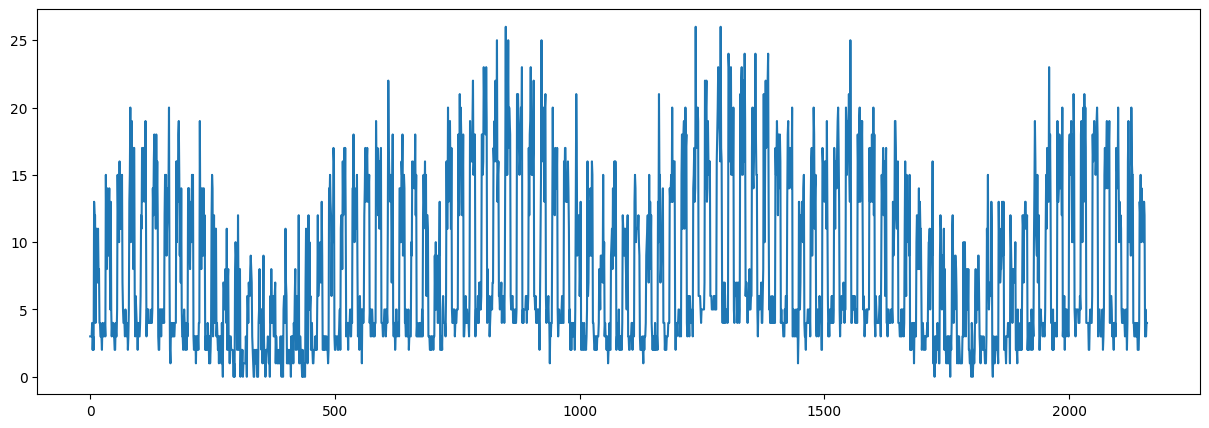

In [7]:
# Visualize the target variable over time
df.y.plot(figsize= ( 15,5))
plt.show()

In [8]:
# Show information about the DataFrame and check the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   datetime       2160 non-null   object 
 1   location_name  2160 non-null   object 
 2   y              2160 non-null   int64  
 3   day_of_week    2160 non-null   int64  
 4   temperature    2160 non-null   float64
 5   rainfall       2160 non-null   int64  
 6   event_day      2160 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 118.3+ KB


In [9]:
# Check the unique locations in the dataset
df.location_name.unique()

array(['Sydney', 'Melbourne', 'Brisbane'], dtype=object)

In [10]:
# Convert the DataFrame into a TimeSeriesDataFrame object
timeseries_df = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column = 'location_name',
    timestamp_column = "datetime"
    )
# Quick preview of the new TimeSeriesDataFrame
timeseries_df.tail()

y  day_of_week  temperature  rainfall  event_day
item_id  timestamp                                                            
Brisbane 2024-06-30 19:00:00  3            6    13.413679         0          0
         2024-06-30 20:00:00  5            6    16.786890         0          0
         2024-06-30 21:00:00  3            6    14.566363         0          0
         2024-06-30 22:00:00  4            6    14.387770         1          0
         2024-06-30 23:00:00  4            6    16.239709         0          0

In [11]:
# Prediction of the number of values
prediction_length = 216

# Autogluon Model - Simple

We specify a prediction length and build a simple AutoGluon time-series model. We train it, list the models used, check the leaderboard, and generate predictions.

In [12]:
# Initialize the TimeSeriesPredictor with essential parameters
predictor = TimeSeriesPredictor(
    prediction_length = prediction_length,
    target = 'y',
    eval_metric = 'RMSE',
    freq = "h"
    )

In [13]:
# Train the model with specified presets, validation steps, and time limits
predictor.fit(
    timeseries_df,
    presets = 'best_quality',
    val_step_size = 96,
    random_seed = 1502,
    num_val_windows = 50,
    time_limit = 600
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/content/drive/MyDrive/Python - Time Series Forecasting/Advanced Content for Time Series /Amazon AutoGluon/AutogluonModels/ag-20250117_152711'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          12
GPU Count:          1
Memory Avail:       81.19 GB / 83.48 GB (97.3%)
Disk Space Avail:   193.41 GB / 235.68 GB (82.1%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'freq': 'h',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 50,
 'prediction_length': 216,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 1502,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/821M [00:00<?, ?B/s]

	-3.7970       = Validation score (-RMSE)
	46.21   s     = Training runtime
	1.27    s     = Validation (prediction) runtime
Training timeseries model ChronosFineTuned[bolt_small]. Training for up to 79.0s of the 474.0s of remaining time.
	Skipping covariate_regressor since the dataset contains no covariates or static features.


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/191M [00:00<?, ?B/s]

	Saving fine-tuned model to /content/drive/MyDrive/Python - Time Series Forecasting/Advanced Content for Time Series /Amazon AutoGluon/AutogluonModels/ag-20250117_152711/models/ChronosFineTuned[bolt_small]/W0/fine-tuned-ckpt
	Saving fine-tuned model to /content/drive/MyDrive/Python - Time Series Forecasting/Advanced Content for Time Series /Amazon AutoGluon/AutogluonModels/ag-20250117_152711/models/ChronosFineTuned[bolt_small]/W1/fine-tuned-ckpt
	Saving fine-tuned model to /content/drive/MyDrive/Python - Time Series Forecasting/Advanced Content for Time Series /Amazon AutoGluon/AutogluonModels/ag-20250117_152711/models/ChronosFineTuned[bolt_small]/W2/fine-tuned-ckpt
	-5.0041       = Validation score (-RMSE)
	75.18   s     = Training runtime
	0.09    s     = Validation (prediction) runtime
Training timeseries model TemporalFusionTransformer. Training for up to 79.7s of the 398.7s of remaining time.
	-5.6275       = Validation score (-RMSE)
	77.34   s     = Training runtime
	0.04    s   

In [14]:
# List the model names
predictor.model_names()

['SeasonalNaive',
 'RecursiveTabular',
 'DirectTabular',
 'NPTS',
 'AutoETS',
 'ChronosZeroShot[bolt_base]',
 'ChronosFineTuned[bolt_small]',
 'TemporalFusionTransformer',
 'DeepAR',
 'PatchTST',
 'TiDE',
 'WeightedEnsemble']

In [15]:
# Show performance of trained models
predictor.leaderboard()

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-3.188303,2.312096,3.532180,12
1,NPTS,-3.644522,0.756862,1.265076,4
2,DeepAR,-3.759985,1.081199,78.061343,9
3,ChronosZeroShot[bolt_base],-3.796982,1.269929,46.210201,6
4,SeasonalNaive,-4.155233,0.029001,2.952132,1
5,DirectTabular,-4.226383,0.100937,2.162443,3
6,RecursiveTabular,-4.649663,2.857396,8.613672,2
7,ChronosFineTuned[bolt_small],-5.004074,0.093302,75.180449,7
8,TemporalFusionTransformer,-5.627462,0.041653,77.343039,8
9,PatchTST,-6.103272,0.041535,57.038009,10


In [16]:
# Generate predictions using the trained model
predictions = predictor.predict(timeseries_df, random_seed = 1502)
predictions.head()

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                               
Sydney  2024-07-01 00:00:00  3.050943  1.199991  1.585849  2.247173  2.875252   
        2024-07-01 01:00:00  2.871036  0.934432  1.770535  2.055461  2.297762   
        2024-07-01 02:00:00  3.229740  1.409066  1.845776  2.159986  2.864979   
        2024-07-01 03:00:00  2.857753  0.703176  1.601895  1.955623  2.686218   
        2024-07-01 04:00:00  3.077808  0.745903  1.707175  2.511825  2.832750   

                                  0.5       0.6       0.7       0.8       0.9  
item_id timestamp                                                              
Sydney  2024-07-01 00:00:00  3.056796  3.666476  3.867635  4.098064  4.886602  
        2024-07-01 01:00:00  2.963903  3.188078  3.874562  4.165532  4.551957  
        2024-07-01 02:00:00  3.125735  3.810830  4.073369  4.803860  5.240342  
        2024-07-01 03:00:00  2.969537  3.251441  3.541958  3.885380  5.226474  
        2024-07-01 04:00:00  3.137433  3.434802  4.176574  4.544987  5.055904

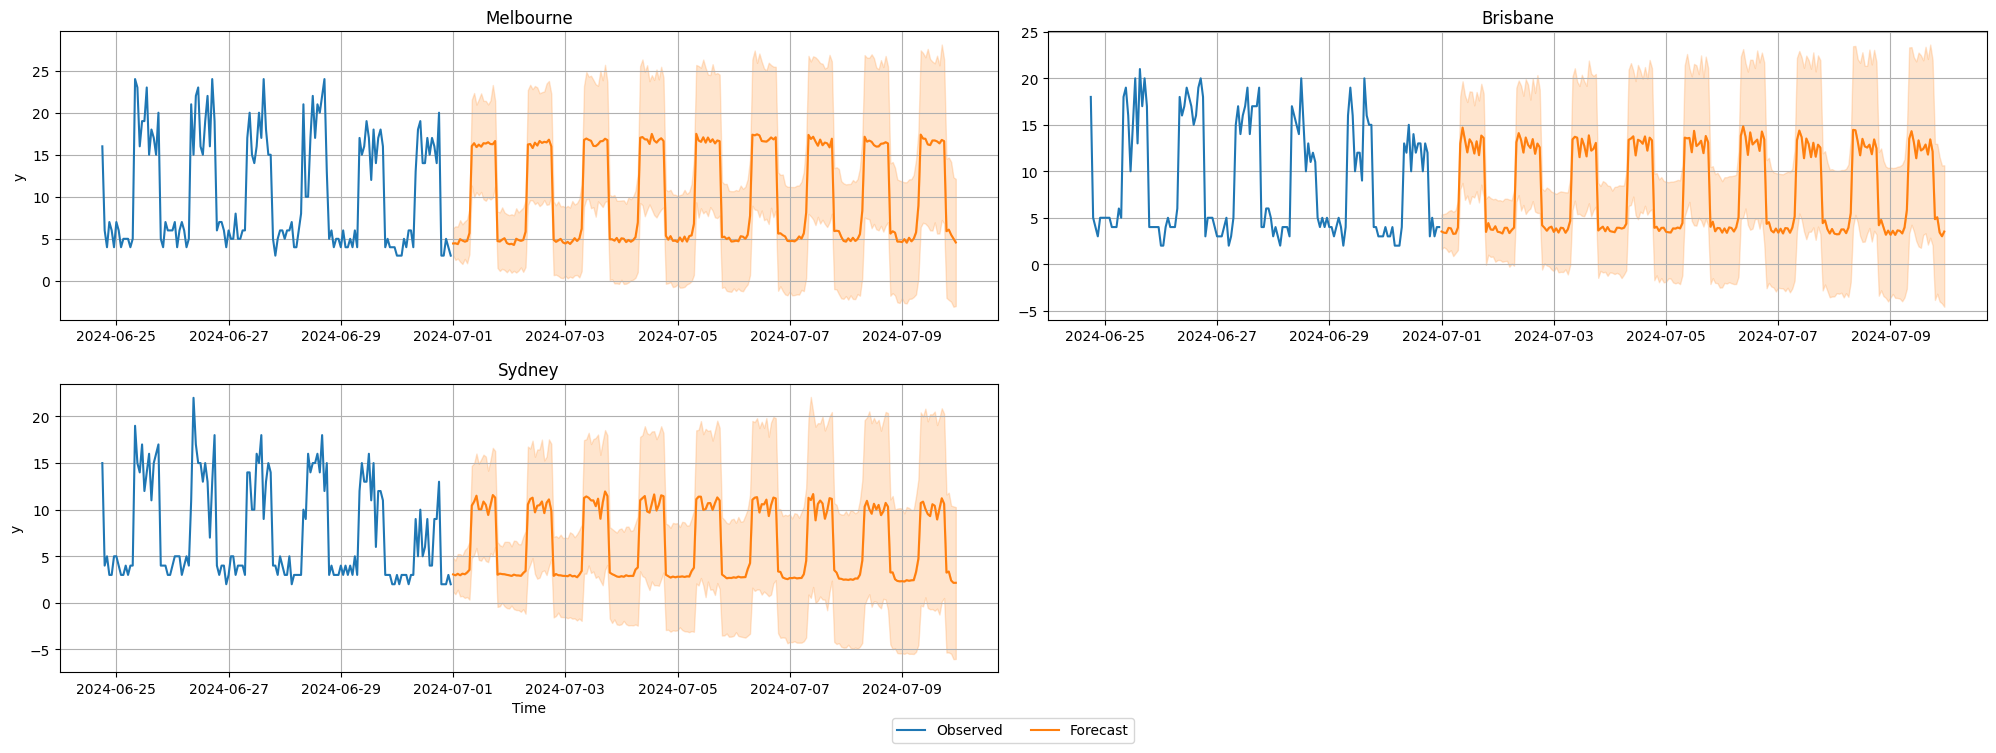

In [17]:
# Plot the actual time series along with the model predictions
predictor.plot(timeseries_df, predictions, max_history_length = 150);

We have a simple model trained on the data. Its performance metrics give us a quick baseline.

# AutoGluon with Covariates

We load future covariates, convert them into the correct format, and retrain the model by including extra features like event days and day of week.


In [18]:
# Load future covariates to enrich the forecasting process
future_covariates = pd.read_csv("australia_library_future.csv")
future_covariates.head()

,datetime,location_name,day_of_week,event_day
0,2024-07-01 00:00:00,Sydney,0,0
1,2024-07-01 01:00:00,Sydney,0,0
2,2024-07-01 02:00:00,Sydney,0,0
3,2024-07-01 03:00:00,Sydney,0,0
4,2024-07-01 04:00:00,Sydney,0,0


In [19]:
# Convert the future covariates DataFrame into a TimeSeriesDataFrame
future_timeseries_df = TimeSeriesDataFrame.from_data_frame(
    future_covariates,
    id_column = 'location_name',
    timestamp_column = "datetime"
    )

In [20]:
# Initialize the TimeSeriesPredictor with known covariates
predictor2 = TimeSeriesPredictor(
    prediction_length = prediction_length,
    target = 'y',
    eval_metric = 'RMSE',
    freq = "h",
    known_covariates_names = ['event_day', 'day_of_week']
)

In [21]:
# Train the model using the covariates
predictor2.fit(
    timeseries_df,
    presets = "best_quality",
    val_step_size = 96,
    random_seed = 1502,
    num_val_windows = 50,
    time_limit = 600
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/content/drive/MyDrive/Python - Time Series Forecasting/Advanced Content for Time Series /Amazon AutoGluon/AutogluonModels/ag-20250117_153550'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          12
GPU Count:          1
Memory Avail:       78.58 GB / 83.48 GB (94.1%)
Disk Space Avail:   191.87 GB / 235.68 GB (81.4%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'freq': 'h',
 'hyperparameters': 'default',
 'known_covariates_names': ['event_day', 'day_of_week'],
 'num_val_windows': 50,
 'prediction_length': 216,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 1502,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'ski

In [22]:
# Display the leaderboard for the new model
predictor2.leaderboard(silent = True)

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-3.207368,2.555135,3.534870,12
1,DynamicOptimizedTheta,-3.629636,0.161477,48.063348,4
2,NPTS,-3.637011,0.806208,1.289338,3
3,ChronosZeroShot[bolt_base],-3.797014,1.154840,2.453995,6
4,DeepAR,-3.919938,1.093657,89.119278,9
5,SeasonalNaive,-4.155233,0.030089,0.104546,1
6,DirectTabular,-4.185262,0.089407,3.003180,2
7,ChronosFineTuned[bolt_small],-5.352416,0.105005,84.965334,7
8,TemporalFusionTransformer,-5.670929,0.049176,88.139646,8
9,PatchTST,-6.034153,0.047959,70.794471,10


In [23]:
# Check the future timeseries data
future_timeseries_df

day_of_week  event_day
item_id  timestamp                                  
Sydney   2024-07-01 00:00:00            0          0
         2024-07-01 01:00:00            0          0
         2024-07-01 02:00:00            0          0
         2024-07-01 03:00:00            0          0
         2024-07-01 04:00:00            0          0
...                                   ...        ...
Brisbane 2024-07-09 19:00:00            1          1
         2024-07-09 20:00:00            1          1
         2024-07-09 21:00:00            1          1
         2024-07-09 22:00:00            1          1
         2024-07-09 23:00:00            1          1

[648 rows x 2 columns]

In [24]:
# Generate predictions using known covariates
predictions2 = predictor2.predict(
    timeseries_df,
    random_seed = 1502,
    known_covariates = future_timeseries_df)
predictions2.head()

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                               
Sydney  2024-07-01 00:00:00  2.826372  0.626755  1.491467  1.889547  2.487646   
        2024-07-01 01:00:00  2.763609  0.152803  1.149728  1.674316  2.368074   
        2024-07-01 02:00:00  3.086593  0.052668  1.170125  1.783559  2.565385   
        2024-07-01 03:00:00  2.723711 -0.512079  0.674925  1.369884  2.210401   
        2024-07-01 04:00:00  2.913891 -0.573682  0.485784  1.488499  2.386018   

                                  0.5       0.6       0.7       0.8       0.9  
item_id timestamp                                                              
Sydney  2024-07-01 00:00:00  2.804697  3.372210  3.716198  4.116399  4.957539  
        2024-07-01 01:00:00  2.794520  3.212034  3.667995  4.447782  5.429623  
        2024-07-01 02:00:00  3.062410  3.801344  4.319340  4.915011  6.026253  
        2024-07-01 03:00:00  2.762176  3.319602  3.894309  4.571350  6.031748  
        2024-07-01 04:00:00  2.992871  3.598871  4.231346  5.231706  6.280723

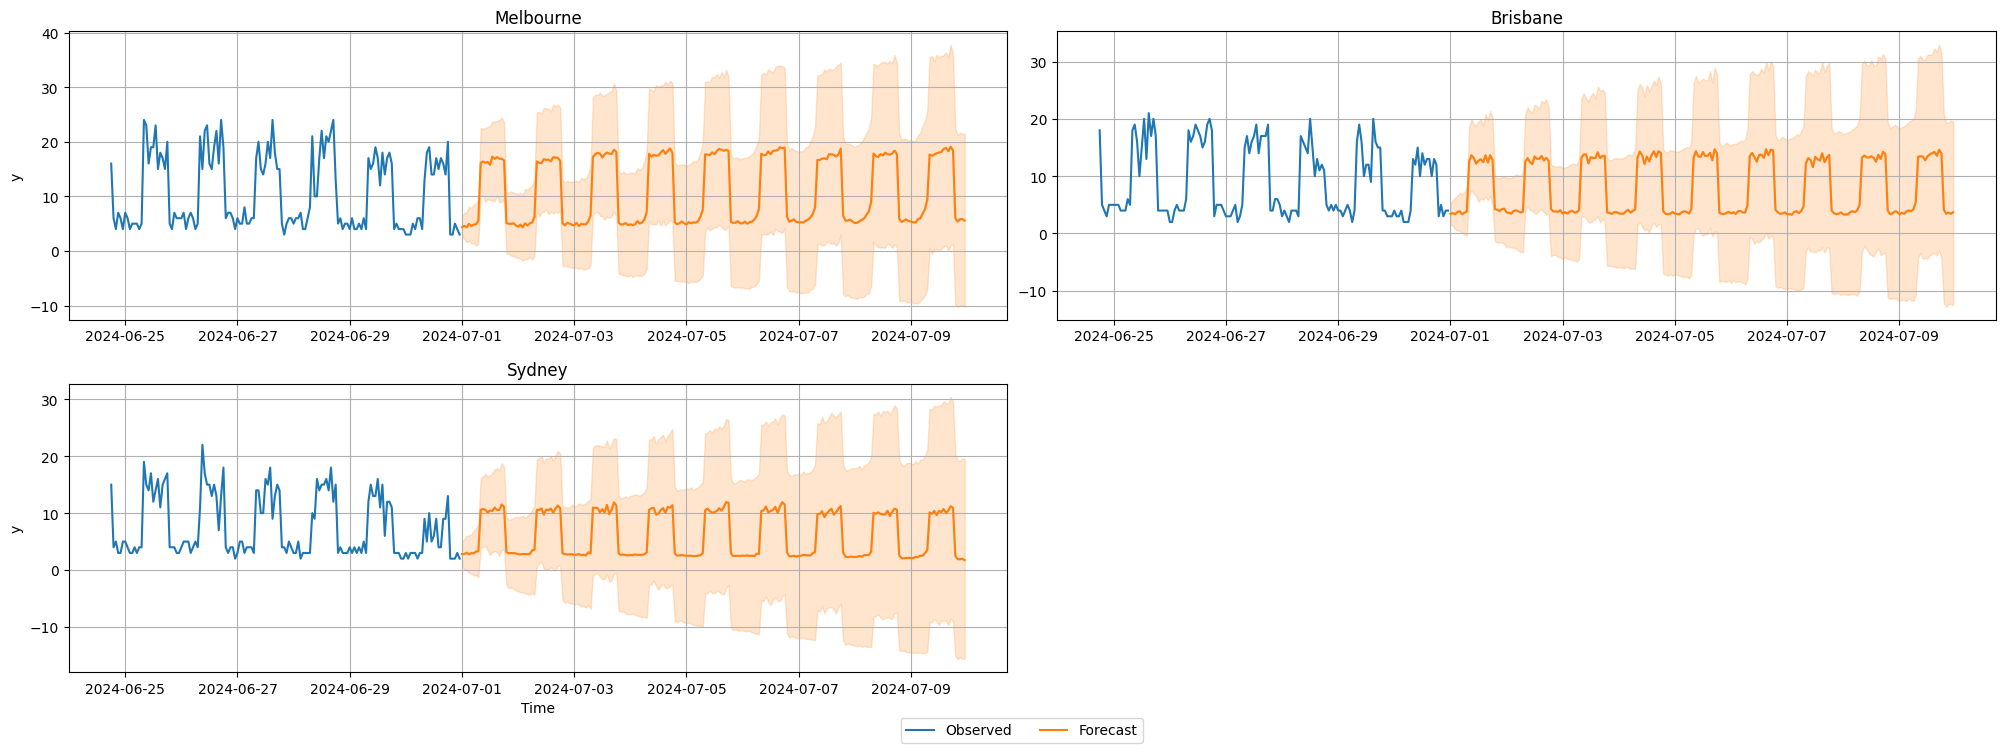

In [25]:
# Plot the actual time series and predictions
predictor2.plot(timeseries_df, predictions2, max_history_length = 150);

We have now included extra features to boost the model's understanding of the data and refine the forecasts.

# Interpretability

We generate and visualize the feature importance to see which features have the biggest impact on the model's predictions.

In [ ]:
# Extract and store the feature importance metrics
feature_importance = predictor2.feature_importance(
    timeseries_df
)

Computing feature importance
Subsample_size 50 is larger than the number of items in the data and will be ignored


In [ ]:
# Display the feature importance DataFrame
feature_importance

,importance,stdev,n,p99_low,p99_high
event_day,0.005311,0.0,5.0,0.005311,0.005311
day_of_week,0.000000,0.0,5.0,0.000000,0.000000
rainfall,0.000000,0.0,0.0,NaN,NaN
temperature,0.000000,0.0,0.0,NaN,NaN


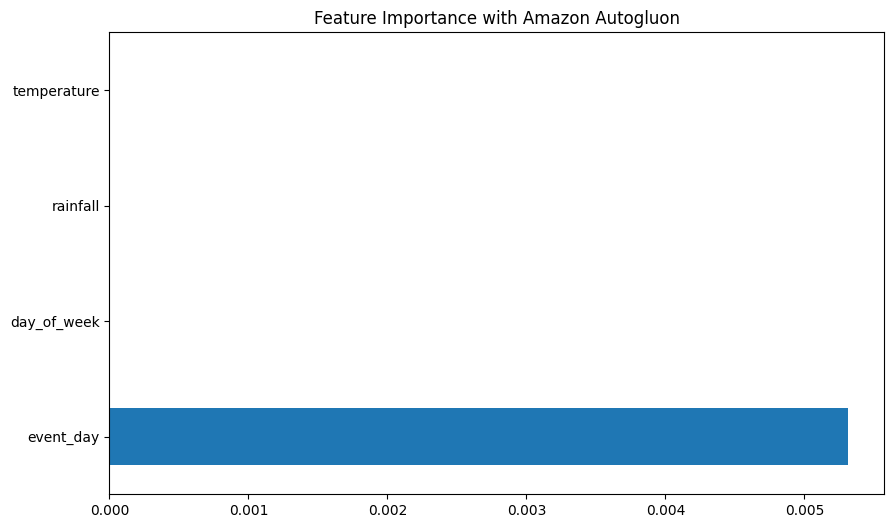

In [ ]:
# Plot the feature importance for a clear picture
feature_importance.importance.plot(kind = 'barh', figsize = (10, 6))
plt.title("Feature Importance with Amazon Autogluon")
plt.show();

# Conclusion
We successfully set up an AutoGluon time-series forecasting pipeline, used both basic and covariate-enhanced models, and interpreted the results with feature importance. You can now build on this workflow to make data-driven decisions about library visitor trends in different Australian cities.

